In [7]:
# import miscellaneous helper libraries
import os
import imutils
from imutils import paths
from loader_util.nn.conv import ShallowNetTorch

# import pytorch imports
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# import numpy-pandas imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
sns.set()


# check if CUDA is available or not
if not torch.cuda.is_available():
    print('CUDA is not available. Tranin on CPU....')
else:
    print('CUDA is available! Training on GPU')
    device = torch.device("cuda")

CUDA is available! Training on GPU


In [8]:
# construct imagePaths
pyth_dir = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH"
image_folder = os.path.join(pyth_dir,
                            'DeepLearning',
                            'DeepLearning-DL4CV',
                            'Edition3',
                            'SB_Code',
                            'datasets',
                            'animals')
args = {
    'dataset': image_folder
}
imagePaths = list(paths.list_images(args['dataset']))

In [9]:
# Construct Transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize(size=(32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

valid_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# create and load the dataset
data = datasets.ImageFolder(image_folder, transform=valid_transforms) 
data_len = len(data)
data_indices = list(range(data_len))

test_data_percentage = 10
test_data_len = int(np.floor(data_len * test_data_percentage / 100))

test_idx, train_idx = data_indices[:test_data_len], \
                      data_indices[test_data_len:]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainLoader = DataLoader(dataset=data,
                         batch_size=32,
                         sampler=train_sampler)
validLoader = DataLoader(dataset=data,
                         batch_size=32,
                         sampler=test_sampler)

In [10]:
# initialise the model on CUDA
model = ShallowNetTorch(width=64, height=64, depth=3, classes=3)
model.to(device)

ShallowNetTorch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): ReLU()
  (fc1): Linear(in_features=131072, out_features=3, bias=True)
)

In [11]:
len(validLoader)

10

In [14]:
# Train the model
epochs = 10
epoch_train_losses = []
epoch_train_accus = []
epoch_valid_losses = []
epoch_valid_accus = []

# define the loss
criterion = nn.CrossEntropyLoss()

# create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# loop over the epochs
for epoch in range (1, epochs + 1):
    
    # keep track of all losses
    running_train_loss = 0
    running_valid_loss = 0
    
    running_train_acc = 0
    running_valid_acc = 0
    
    train_batch_no = 0
    test_batch_no = 0
    
    # TRAIN
    model.train()
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        train_batch_no += 1
        
        # Training pass
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        
        # exponentiate the logits
        exp_logits = torch.exp(logits)
        
        # pass thru softmax to calculate probs
        probs = exp_logits / (torch.sum(exp_logits, dim=1).view(exp_logits.shape[0],-1))
        
        # get top class and to class prob
        top_p, top_class = probs.topk(1, dim=1)
        
        # reshape labels into column vector
        labels = labels.view(labels.shape[0], -1)
    
        # find which labels are correctly classified
        acc_boolean = top_class == labels
       
        # finally calculate accuracy
        running_train_acc += np.sum(acc_boolean.cpu().numpy()) / len(acc_boolean)
        
        
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    else:
        # dividing because running loss is the sum loss of all batches 
        epoch_train_loss = running_train_loss / train_batch_no
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_accu = running_train_acc / train_batch_no
        epoch_train_accus.append(epoch_train_accu)
        print(f"Epoch: {epoch}")
        print(f'{train_batch_no} train batches completed')
        
        
    
    # VALIDATE
    model.eval()
    for images, labels in validLoader:
        images, labels = images.to(device), labels.to(device)
        test_batch_no += 1
        
        # Validation pass
        logits = model(images)
        loss = criterion(logits, labels)
        
        # exponentiate the logits
        exp_logits = torch.exp(logits)
        
        # pass thru softmax to calculate probs
        probs = exp_logits / (torch.sum(exp_logits, dim=1).view(exp_logits.shape[0],-1))
        
        # get top class and to class prob
        top_p, top_class = probs.topk(1, dim=1)
        
        # reshape labels into column vector
        labels = labels.view(labels.shape[0], -1)
    
        # find which labels are correctly classified
        acc_boolean = top_class == labels
       
        # finally calculate accuracy
        running_valid_acc += np.sum(acc_boolean.cpu().numpy()) / len(acc_boolean)

        running_valid_loss += loss.item()
    else:
        # dividing because running loss is the sum loss of all batches 
        epoch_test_loss = running_valid_loss / test_batch_no
        epoch_test_accu = running_valid_acc / test_batch_no
        epoch_valid_losses.append(epoch_test_loss)
        epoch_valid_accus.append(epoch_test_accu)
        print ( f"Training loss: {epoch_train_loss} " )
        print(f'Train accu: {epoch_train_accu}')
        print(f'{test_batch_no} test batches completed')
        print ( f"Validation loss: {epoch_test_loss}")
        print(f'Validation accu: {epoch_test_accu}')
        print("=" * 50)

Epoch: 1
85 train batches completed
Training loss: 0.0006236118428847369 
Train accu: 1.0
10 test batches completed
Validation loss: 2.807943320274353
Validation accu: 0.5
Epoch: 2
85 train batches completed
Training loss: 0.0006188927909961956 
Train accu: 1.0
10 test batches completed
Validation loss: 2.855488634109497
Validation accu: 0.5052083333333333
Epoch: 3
85 train batches completed
Training loss: 0.0006105310194577803 
Train accu: 1.0
10 test batches completed
Validation loss: 2.906231415271759
Validation accu: 0.5041666666666667
Epoch: 4
85 train batches completed
Training loss: 0.000604245183058083 
Train accu: 1.0
10 test batches completed
Validation loss: 3.002025508880615
Validation accu: 0.5083333333333333
Epoch: 5
85 train batches completed
Training loss: 0.000597945849329014 
Train accu: 1.0
10 test batches completed
Validation loss: 2.8842676877975464
Validation accu: 0.5041666666666667
Epoch: 6
85 train batches completed
Training loss: 0.0005880999796585563 
Train a

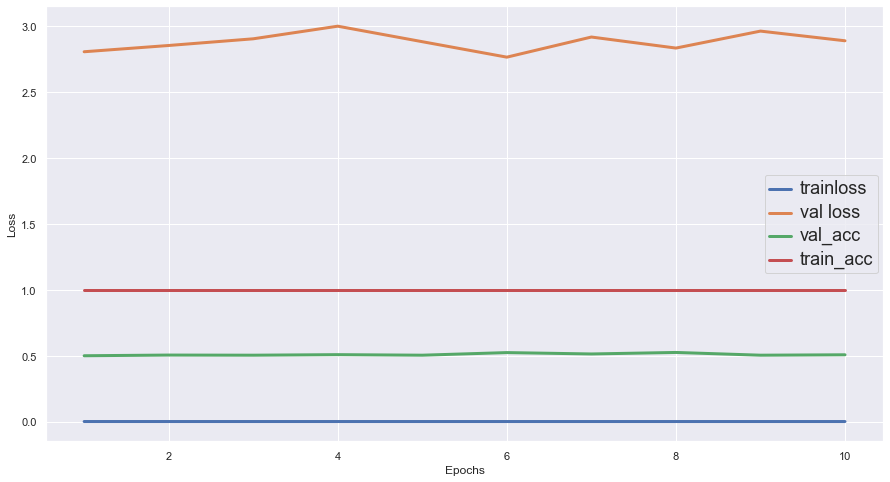

In [15]:
# evaluate the network
# plot the performance
import pandas as pd
epochs = range(1, epochs+1)
plot_df = pd.DataFrame(data=np.c_[epochs, epoch_train_losses, 
                                  epoch_valid_losses, epoch_train_accus, 
                                  epoch_valid_accus], 
                       columns=['epochs','train_loss', 'test_loss', 
                                'train_acc', 'valid_acc'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='train_loss', ax=ax, label='trainloss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='test_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='valid_acc', ax=ax, label='val_acc', 
             linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='train_acc', ax=ax, 
             label='train_acc', linewidth=3)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text